# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import TruncatedSVD # SVD for sparse matrices
from sklearn.preprocessing import normalize # normalization for sparse matrices

In [2]:
import gensim
# for preprocessing
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
# for bigrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.stem.porter import *
import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet
from gensim import corpora, models
from pprint import pprint

stemmer = SnowballStemmer('english')

# Functions

In [3]:
def preprocess(text, stopwords=[], min_token_length=3):
    """
    Takes a dataframe's text column and preprocesses it by:
        * Removing typical English stop words and removing stop words designated by user
        * Lemmatizing words
        
    ------PARAMETERS------
    text: dataframe column
    stopwords: list of *lower case* stop words to remove
    min_token_length: minimum character length of a word (e.g, if it is 3, 'an' is removed)
    
    ------OUTPUT------
    result: a dataframe column with a list of words to feed into other nlp functions
        (create_nlp_items_from_preprocessed_df)
    """
    # Lemmatize and stem preprocessing steps on the data set.
    def lemmatize_stemming(text):
        return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > min_token_length:
            result.append(lemmatize_stemming(token))
    result = [item for item in result if item not in stopwords]
    
    return result

In [4]:
def create_nlp_items_from_preprocessed_df(df_column,
                                          no_below=2,
                                          no_above=1.0,
                                          keep_n=None,
                                          verbose=True):
    """
    Creates key NLP items from a pandas dataframe column that's already been preprocessed ('preprocess' function).
    ------PARAMETERS------
    df_column: dataframe column of text
    no_below: int, only include words that appear in this many documents
    no_above: float, exclude all words that appear in this proportion of documents (1.0 = 100%)
    keep_n: maximum number of terms to keep
    verbose: show progress with output previews and etc.
    
    ------OUTPUT (in order)------
    A dictionary
    The bag of words corpus corresponding with the dictionary
    A tfidf 'model' for gensim
    A tfidf in corpus form
    A sparse tfidf *matrix*, readily usable for further calculations.
    """
    dictionary = gensim.corpora.Dictionary(metadata['gensim_abstract_processed'])
    if verbose:
        count = 0
        for k, v in dictionary.iteritems():
            print(k, v)
            count += 1
            if count > 10:
                break
        print('\n ' + str(len(dictionary)) + ' unique words. \n')
        
    if keep_n == None:
        keep_n = len(dictionary)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=keep_n)
    
    if verbose:
        print(str(len(dictionary)) + ' unique words after extremes filtered. \n')
        print('')
        
    bow_corpus = [dictionary.doc2bow(doc) for doc in df_column]
    
    if verbose:
        # Preview the corpus
        bow_doc_n = bow_corpus[np.random.choice(list(range(len(df_column))))]
        for i in range(len(bow_doc_n)):
            print("Word {} (\"{}\") appears {} time.".format(bow_doc_n[i][0], 
                                                       dictionary[bow_doc_n[i][0]], 
                    bow_doc_n[i][1]))
    
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    if verbose:
        print('\n Corpus TF-IDF preview:')
        for doc in corpus_tfidf:
            pprint(doc)
            break
          
    # .T to transpose since it's a word-doc matrix, not doc-word matrix (we want rows as docs)
    tfidf_sparse = gensim.matutils.corpus2csc(corpus_tfidf, printprogress=500).T
        
    return dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse

# Read in Small Data (metadata)

In [5]:
metadata = pd.read_csv('big_data/metadata.csv')
metadata = metadata[pd.isnull(metadata['abstract']) == False].reset_index(drop=True)

Using the search query to focus on abstracts:
"COVID-19" OR Coronavirus OR "Corona virus" OR "2019-nCoV" OR "SARS-CoV" OR "MERS-CoV" OR “Severe Acute Respiratory Syndrome” OR “Middle East Respiratory Syndrome” 

In [6]:
 metadata = metadata[metadata['abstract'].str.lower().str.contains(
     "covid-19|coronavirus|coronavirus|corona virus|2019-ncov|sars-cov|mers-cov|severe acute respiratory syndrome|middle east respiratory syndrome") | 
         metadata['abstract'].str.contains("MERS")
         ]

In [7]:
count = sum(metadata['abstract'].str.contains('COVID'))
print('There are ' + str(count) + ' articles mentioning COVID, which likely refers to COVID-19.')

count = sum(metadata['abstract'].str.contains('COVID-19'))
print('There are ' + str(count) + ' articles mentioning COVID-19.')

count = sum(metadata['abstract'].str.contains('COVID-19')[(pd.isnull(metadata['abstract']) == False) & 
                                                          (metadata['abstract'].str.contains('COVID-19'))
                                                         ] 
           )
print('There are ' + str(count) + ' articles mentioning COVID and COVID-19.')

There are 899 articles mentioning COVID, which likely refers to COVID-19.
There are 881 articles mentioning COVID-19.
There are 881 articles mentioning COVID and COVID-19.


In [8]:
covid_article_indexes = np.argwhere(metadata['abstract'].str.contains('COVID')).T[0]

C:\Users\vldoa\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


# Traditional ML

## Preprocessing

In [9]:
t = time.time()
metadata['gensim_abstract_processed'] = metadata['abstract'].map(
    lambda p: preprocess(p, stopwords=['abstract'])
)
print(time.time() - t)

49.76815128326416


Some preliminary work on bigram integration below (ignore for now).

In [10]:
# def get_bigrams_from_preprocessed(preprocessed_col, min_count=0.1, threshold=0.00000000000001**10):
#     x = Phrases(preprocessed_col, min_count=min_count, threshold=threshold)
#     x = Phraser(x)

#     bigram_token = []
#     for sent in preprocessed_col:
#         bigram_token.append(x[sent])
    
#     return bigram_token

In [11]:
# x = get_bigrams_from_preprocessed(metadata['gensim_abstract_processed'])

In [12]:
# x[0]

In [13]:
# metadata['abstract'].tolist()[0]

In [14]:
# metadata['gensim_abstract_processed'].tolist()[0]

In [15]:
# i = 29
# print(metadata['gensim_abstract_processed'][i])
# metadata['abstract'][i]

Create key NLP objects for word counts

In [16]:
dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = create_nlp_items_from_preprocessed_df(
    metadata['gensim_abstract_processed'],
    no_below=2,
    verbose=True)

0 canin
1 common
2 competit
3 coronavirus
4 describ
5 direct
6 elisa
7 epitop
8 felin
9 peplom
10 prcv

 21241 unique words. 

10330 unique words after extremes filtered. 


Word 3 ("coronavirus") appears 2 time.
Word 12 ("relat") appears 2 time.
Word 21 ("clinic") appears 1 time.
Word 23 ("current") appears 1 time.
Word 25 ("diseas") appears 3 time.
Word 34 ("immun") appears 1 time.
Word 35 ("import") appears 2 time.
Word 38 ("infect") appears 1 time.
Word 39 ("laboratori") appears 3 time.
Word 44 ("organ") appears 1 time.
Word 50 ("respiratori") appears 1 time.
Word 51 ("respons") appears 3 time.
Word 54 ("sever") appears 1 time.
Word 61 ("test") appears 2 time.
Word 65 ("viral") appears 1 time.
Word 66 ("virus") appears 1 time.
Word 86 ("core") appears 1 time.
Word 93 ("earli") appears 1 time.
Word 161 ("antibodi") appears 1 time.
Word 179 ("human") appears 2 time.
Word 180 ("identifi") appears 1 time.
Word 194 ("remain") appears 1 time.
Word 198 ("trace") appears 1 time.
Word 211 (

## PCA

## Implementation

In [17]:
tfidf_sparse_norm = normalize(tfidf_sparse, norm='l1', axis=1)

(0, 1.01)

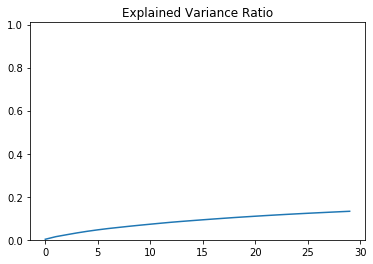

In [18]:
truncatedsvd = TruncatedSVD(n_components = 30, algorithm = 'randomized', random_state = 20)

transformed = truncatedsvd.fit_transform(tfidf_sparse_norm)

plt.title('Explained Variance Ratio')
plt.plot(np.cumsum(truncatedsvd.explained_variance_ratio_)[0:30])
plt.ylim(0, 1.01)

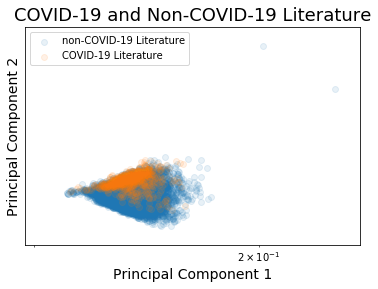

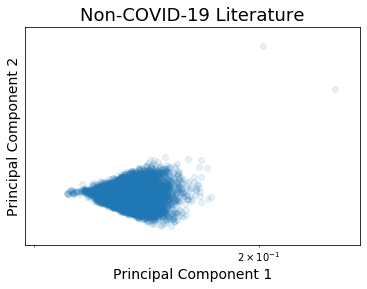

In [19]:
xscale_log_addition = 0.1

not_covid = (np.isin(np.array(list(range(len(transformed)))), covid_article_indexes) == False)
plt.scatter(transformed[not_covid,0] + xscale_log_addition,
            transformed[not_covid,1], alpha=0.1, label='non-COVID-19 Literature')

plt.scatter(transformed[covid_article_indexes,0] + xscale_log_addition,
            transformed[covid_article_indexes,1], alpha=0.1, label='COVID-19 Literature')
# plt.yscale('log')
plt.xscale('log')
plt.title('COVID-19 and Non-COVID-19 Literature', size=18)
plt.xlabel('Principal Component 1', size=14)
plt.ylabel('Principal Component 2', size=14)
plt.xticks([]); plt.yticks([])
plt.legend()
plt.show()




not_covid = (np.isin(np.array(list(range(len(transformed)))), covid_article_indexes) == False)
plt.scatter(transformed[not_covid,0] + xscale_log_addition,
            transformed[not_covid,1], alpha=0.1)
# plt.yscale('log')
plt.xscale('log')
plt.title('Non-COVID-19 Literature', size=18)
plt.xlabel('Principal Component 1', size=14)
plt.ylabel('Principal Component 2', size=14)
plt.xticks([]); plt.yticks([])
# plt.legend()
plt.show()

<IPython.core.display.Javascript object>


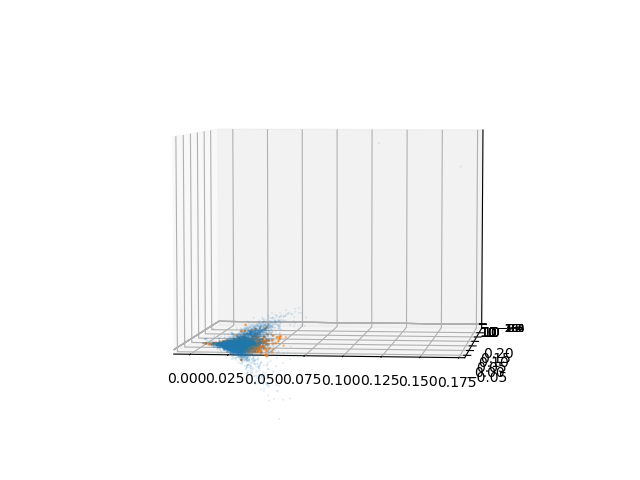

In [59]:
%matplotlib notebook



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(transformed[not_covid,0], transformed[not_covid,1], transformed[not_covid,2], s=0.1, alpha=0.2)
ax.scatter(transformed[covid_article_indexes,0], transformed[covid_article_indexes,1],
           transformed[covid_article_indexes,2], s=1)

# ax.xscale('log')
ax.set_zscale('log')
# ax.set_yscale('log')

## Analysis

In [94]:
c = 1

word_ids_sorted = np.argsort(np.abs(truncatedsvd.components_[c]))[::-1]
top_words = [[dictionary[word_ids_sorted[i]], truncatedsvd.components_[c, word_ids_sorted[i]]] for i in range(50)]
top_words = pd.DataFrame(top_words, columns=['word', 'component_score'])
top_words = top_words.sort_values('component_score')

In [95]:
top_words_pd = top_words.rename({'component_score' : 'component_1'}, axis=1)

In [96]:
c=0
word_ids_sorted = np.argsort(np.abs(truncatedsvd.components_[c]))[::-1]
all_words = [[dictionary[i], truncatedsvd.components_[c, i]] for i in range(truncatedsvd.components_.shape[1])]
all_words = pd.DataFrame(all_words, columns=['word', 'component_0'])

In [97]:
top_words_pd = top_words_pd.merge(all_words)
top_words_pd = top_words_pd[['word', 'component_0', 'component_1']]
top_words_pd.to_csv('big_data/pca-top-words_abstracts-subsetted.csv', index=False)

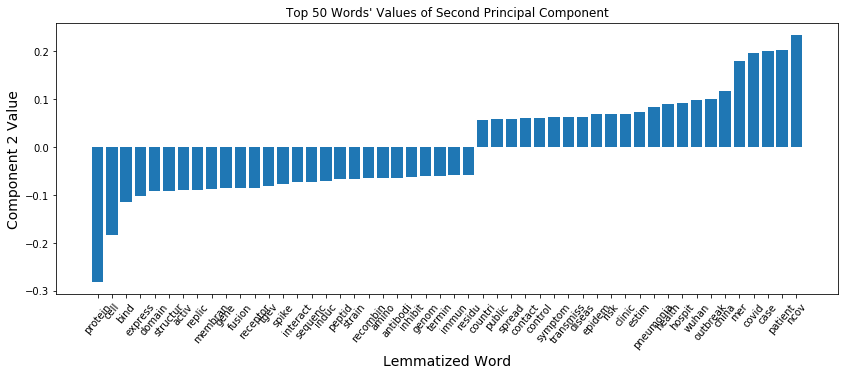

In [112]:
plt.figure(figsize=(14,5))
plt.bar(height=top_words_pd['component_1'], x=top_words_pd['word'])
plt.xticks(rotation=50)
plt.xlabel("Lemmatized Word", size=14)
plt.ylabel("Component 2 Value", size=14)
plt.title("Top 50 Words' Values of Second Principal Component")
plt.show()

In [42]:
metadata['component_0'] = transformed[:,0] * 10**6
metadata['component_1'] = transformed[:,1] * 10**6

metadata['component_0_percentile'] = metadata['component_0'].rank(pct=True)
metadata['component_1_percentile'] = metadata['component_1'].rank(pct=True)

In [22]:
metadata['abstract_COVID'] = metadata['abstract'].str.contains('COVID')

In [23]:
metadata.columns

Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text',
       'full_text_file', 'gensim_abstract_processed', 'component_0',
       'component_1', 'component_0_percentile', 'component_1_percentile',
       'abstract_COVID'],
      dtype='object')

In [26]:
metadata_small = metadata[[
    'title', 'doi', 'pmcid', 'pubmed_id', 'abstract', 'publish_time', 'journal', 
    
    'component_0', 'component_1', 'component_0_percentile', 'component_1_percentile', 'abstract_COVID'
]]
metadata_small.to_csv('big_data/metadata_PCAed_subsetted.csv', sep='|', index=False)

In [25]:
metadata_small

,title,doi,pmcid,pubmed_id,abstract,publish_time,journal,component_0,component_1,component_0_percentile,component_1_percentile,abstract_COVID
27,An ELISA for the detection of serum antibodies...,10.1016/0007-1935(91)90010-K,NaN,1717102.0,Abstract A competition ELISA utilizing a mAb d...,1991-08-31,British Veterinary Journal,28078.244875,-25991.317997,0.629795,0.070029,False
29,Equine arteritis virus: An overview,10.1016/0007-1935(92)90044-2,NaN,1319787.0,Abstract The causative agent of the respirator...,1992-06-30,British Veterinary Journal,16745.907037,-1347.118295,0.090674,0.485630,False
33,Morphology and morphogenesis of a coronavirus ...,10.1016/0014-4800(76)90045-9,NaN,187445.0,Abstract The morphology and morphogenesis of v...,1976-12-31,Experimental and Molecular Pathology,13009.131458,-10803.307786,0.027683,0.329032,False
37,Bovine coronavirus antigen in the host cell pl...,10.1016/0014-4800(90)90039-G,NaN,2261945.0,Abstract Expression of bovine coronavirus (BCV...,1990-10-31,Experimental and Molecular Pathology,24166.605906,-22515.423680,0.422287,0.118827,False
44,Endosomal association of a protein phosphatase...,10.1016/0014-5793(91)80528-B,NaN,1674698.0,Abstract On the assumption that dephosphorylat...,1991-05-06,FEBS Letters,15406.657609,-13085.320712,0.061466,0.289150,False
45,Putative papain-related thiol proteases of pos...,10.1016/0014-5793(91)81034-6,NaN,1652473.0,Abstract A computer-assisted comparative analy...,1991-08-19,FEBS Letters,27325.691087,-23172.722637,0.592962,0.107801,False
51,Influence of coronavirus (transmissible gastro...,10.1016/0016-5085(84)90717-0,NaN,6735081.0,Abstract Four silver—silver chloride electrode...,1984-08-31,Gastroenterology,12194.055505,-780.353176,0.021701,0.495249,False
57,An in-depth study of Crohn's disease in two Fr...,10.1016/0016-5085(93)90401-W,NaN,8425677.0,Abstract Background: Two French families were ...,1993-02-28,Gastroenterology,17792.343482,4961.152465,0.120000,0.591202,False
67,The pathogenesis of nephritis in chickens indu...,10.1016/0021-9975(82)90078-0,NaN,6282945.0,Abstract Nephritis in chickens caused by infec...,1982-04-30,Journal of Comparative Pathology,12416.720750,-4927.540206,0.023226,0.425806,False
76,Pathogenicity and antigen detection of the Nou...,10.1016/0021-9975(92)90068-6,NaN,1313460.0,Abstract We compared the pathogenicity and the...,1992-01-31,Journal of Comparative Pathology,14596.154901,-6387.774775,0.046217,0.404106,False


## Clustering